## Summary
#### Dataset
* This dataset tries to capture customer purchase behavior in __baby__ category. 
* This dataset includes __100__ mother users from the mother cluster, resulting from K-means clustering based on purchase history.
* The K-means clustering was performed on top __20%__ users of year 2017.
* For each dataset, datapoint was sampled at uniform time interval (7 days).
* For each sampled reference time, the sample is labelled __1__ if user placed an order in __baby__ category within __7 days__. Otherwise it's labelled __0__.

#### Features
- [x] Exponential moving averages of aggregate spending (ema)
- [o] Average days between orders (dpo)
- [x] Average days per quantity purchased (dpq)
- [o] Days since last purchase in all categories (dsl)
- [x] Average browse between consecutive purchases in all categories (bpo, bpo_e)
- [x] Average browse per quantity purchased (bpq)
- [x] Browse since most recent purchase (bsl)
- [x] Average GMV per day between consecutive purchases (gpo, gpo_e)
- [x] GMV / order (gpo)
- [x] GMV / quantity (gpq)
- [x] GMV / day = (GMV / order) / (day / order) (gpd)
- [x] GMV per day since most recent purchase in category (gsl)

#### Model
* 3-Layered Neural Net
* See def Build_Model() for details
* __Only 2 features are included__: days per order (gpo), days since last order (dsl)

#### Performance
* baseline = 0.59217
* True positive(tp) = 77
* True negative(tn) = 213
* False positive(fp) = 44
* False negative(fn) = 100
* precision = 0.63636
* recall = 0.43503
* accuracy = 0.66820
* True Positive Rate(TPR) = 0.43503
* False Positive Rate(FPR) = 0.17121

In [1]:
%run -i 'py/load_libraries.py'

## Load Dataset

In [2]:
file_prefix = "sample_100_dataset_v2_d7"
sub_dir = "data"

In [3]:
path = os.path.join(cwd, sub_dir, file_prefix + ".csv")
df = pd.read_csv(path, sep = ",")

print(df.shape)

(4339, 14)


In [4]:
nans = lambda df: df[df.isnull().any(axis=1)]
nans(df).shape

(0, 14)

In [5]:
df_inspect = pd.DataFrame(columns = df.columns.insert(0, "note"))

min_ = np.min(df, axis = 0)
min_["note"] = "min"
df_inspect = df_inspect.append(min_, ignore_index=True)

pct_25 = {df.columns[i] : np.percentile(df, 25, axis = 0)[i] for i in range(len(np.percentile(df, 25, axis = 0)))}
pct_25["note"] = "pct_25"
df_inspect = df_inspect.append(pct_25, ignore_index=True)

pct_50 = {df.columns[i] : np.percentile(df, 50, axis = 0)[i] for i in range(len(np.percentile(df, 25, axis = 0)))}
pct_50["note"] = "pct_50"
df_inspect = df_inspect.append(pct_50, ignore_index=True)

pct_75 = {df.columns[i] : np.percentile(df, 75, axis = 0)[i] for i in range(len(np.percentile(df, 25, axis = 0)))}
pct_75["note"] = "pct_75"
df_inspect = df_inspect.append(pct_75, ignore_index=True)

max_ = np.max(df, axis = 0)
max_["note"] = "max"
df_inspect = df_inspect.append(max_, ignore_index=True)

mu_ = np.mean(df, axis = 0)
mu_["note"] = "mean"
df_inspect = df_inspect.append(mu_, ignore_index=True)

std_ = np.std(df, axis = 0)
std_["note"] = "std"
df_inspect = df_inspect.append(std_, ignore_index=True)

nan = {df.columns[i] : len(nans(df[[df.columns[i]]])) * 100 / len(df) for i in range(len(df.columns))}
nan["note"] = "nan"
df_inspect = df_inspect.append(nan, ignore_index=True)

inf = {df.columns[i] : len(df[np.isinf(df[df.columns[i]])]) * 100 / len(df) for i in range(len(df.columns))}
inf["note"] = "inf"
df_inspect = df_inspect.append(inf, ignore_index=True)

In [6]:
df_inspect.set_index("note").T

note,min,pct_25,pct_50,pct_75,max,mean,std,nan,inf
dt,2.017082e+07,2.017113e+07,2.018022e+07,2.018050e+07,2.018073e+07,2.017711e+07,4467.178934,0.0,0.000000
label,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.973266e-01,0.489345,0.0,0.000000
bpo_e,0.000000e+00,1.915252e+01,4.089443e+01,8.162860e+01,1.334143e+03,6.870713e+01,97.614506,0.0,0.000000
gpo_e,-2.130198e+03,2.960211e+03,4.406159e+03,6.601149e+03,7.512000e+04,5.729746e+03,5170.017414,0.0,0.000000
bpo,0.000000e+00,1.230625e+02,2.032609e+02,3.316383e+02,1.966500e+03,2.642065e+02,235.357849,0.0,0.000000
gpo,1.453333e+03,8.687374e+03,1.086947e+04,1.289568e+04,4.685500e+04,1.144161e+04,4025.863024,0.0,0.000000
dpo,0.000000e+00,4.147059e+00,7.189189e+00,1.110345e+01,1.075000e+02,1.021197e+01,12.026557,0.0,0.000000
bpq,0.000000e+00,1.225671e+02,2.046757e+02,3.256611e+02,1.966500e+03,2.630786e+02,234.221532,0.0,0.000000
dpq,0.000000e+00,4.212121e+00,7.122449e+00,1.133333e+01,9.250000e+01,9.861098e+00,10.533185,0.0,0.000000
gpq,2.218000e+03,8.793793e+03,1.072118e+04,1.286509e+04,4.685500e+04,1.145361e+04,4141.515364,0.0,0.000000


## Preprocessing

In [7]:
# drop bad features here
df = df.drop(["gpd"], axis = 1)

In [8]:
df = df.dropna()
print(df.shape)

(4339, 13)


In [9]:
# separate label into another dataframe
df_labl = df[[key_label]]
df_labl.head()

,label
0,1.0
1,1.0
2,0.0
3,1.0
4,0.0


In [10]:
# extract input features
df_data = df.drop([key_dt, key_label], axis = 1)
df_data.head()

,bpo_e,gpo_e,bpo,gpo,dpo,bpq,dpq,gpq,dsl,bsl,gsl
0,35.577199,6182.565262,405.111111,13113.333333,8.444444,331.454545,6.909091,10729.090909,1.0,0.000000,22070.000000
1,29.493984,13309.657084,365.200000,20672.000000,7.800000,304.333333,6.500000,17226.666667,6.0,3.666667,3678.333333
2,29.493984,13309.657084,365.200000,20672.000000,7.800000,304.333333,6.500000,17226.666667,13.0,2.769231,1697.692308
3,25.175932,11122.388021,336.909091,19352.727273,8.272727,285.076923,7.000000,16375.384615,7.0,0.000000,3152.857143
4,25.175932,11122.388021,336.909091,19352.727273,8.272727,285.076923,7.000000,16375.384615,14.0,24.071429,1576.428571


## Gradient Boosting Machine 
* Rank features by importance
* Apply to entire dataset

In [11]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/anaconda2/envs/py3k/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda2/envs/py3k/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [12]:
def modelfit(alg, dtrain, labels, predictors, performCV = True, printFeatureImportance = True, cv_folds = 5):
    #Fit the algorithm on the data
    alg.fit(dtrain, labels)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, 
                                                    dtrain, 
                                                    labels, 
                                                    cv=cv_folds, 
                                                    scoring='accuracy')
    
    #Print model report:
    analysis.log("\nModel Report")
    analysis.log("Accuracy : %.10g" % metrics.accuracy_score(labels, dtrain_predictions))
    analysis.log("AUC Score (Train): %f" % metrics.roc_auc_score(labels, dtrain_predprob))
    
    if performCV:
        analysis.log("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g\n" % (np.mean(cv_score),
                                                                                 np.std(cv_score),
                                                                                 np.min(cv_score),
                                                                                 np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.savefig(os.path.join(cwd, "fig", "feature_importance.png"))

In [13]:
predictors = [x for x in df_data.columns if x not in [key_label, key_dt]]
gbm0 = GradientBoostingClassifier(random_state=10)


Model Report
Accuracy : 0.7121456557
AUC Score (Train): 0.778001
CV Score : Mean - 0.6015305 | Std - 0.02622734 | Min - 0.562212 | Max - 0.6424452



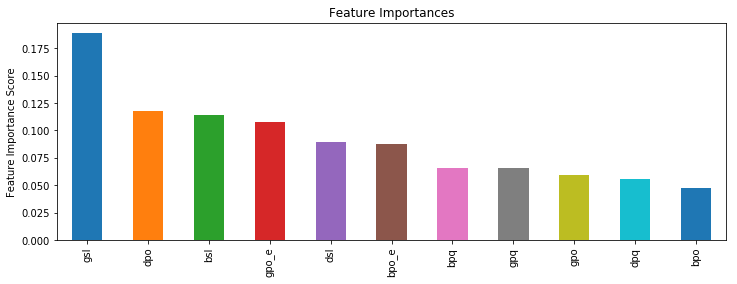

In [14]:
modelfit(gbm0, df_data, df_labl.values.reshape(df_labl.shape[0], ), predictors)

## Build Train-Test Dataset

In [15]:
# choose subset of features to use
features = ["dpq", "dsl"]

# choose train-test split ratio
ratio = 0.9

In [16]:
# normalize
df_data = (df_data - np.mean(df_data)) / np.std(df_data)

In [17]:
df_data = df[features]

df_data.head()
df_data.shape

(4339, 2)

In [18]:
rows = len(df_data)
split = int(rows * ratio)
trn_data = df_data[:split]
trn_labl = df_labl[:split].astype(int)

tst_data = df_data[split:]
tst_labl = df_labl[split:].astype(int)

## Baseline

In [19]:
print("Dataset baseline: %.5f%%"%(analysis.Baseline(df_labl)))
print("Train baseline: %.5f%%"%(analysis.Baseline(trn_labl)))
print("Test baseline: %.5f%%"%(analysis.Baseline(tst_labl)))

Dataset baseline: 60.26734%
Train baseline: 60.38412%
Test baseline: 59.21659%


## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE

In [21]:
logreg = LogisticRegression(max_iter = 10000,
                           verbose = 3)
logreg.fit(trn_data, 
           trn_labl)

[LibLinear]

/anaconda2/envs/py3k/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=3, warm_start=False)

In [22]:
logreg.score(tst_data, 
             tst_labl, 
             sample_weight=None)

0.65668202764976957

In [23]:
pred = logreg.predict(tst_data)
_ = deepcopy(tst_labl)
_["pred"] = pred
_.T

,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,...,4329,4330,4331,4332,4333,4334,4335,4336,4337,4338
label,1,0,1,0,0,0,0,0,1,0,...,1,1,0,1,1,0,1,0,0,1
pred,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
np.sum(pred)

102

## Neural Net Binary Classifier

In [25]:
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.utils import np_utils

Using TensorFlow backend.


In [26]:
def Build_Model():
    nn = Sequential()
    nn.add(Dense(32, activation="relu", input_shape=(len(features),)))
    nn.add(Dense(32, activation="relu"))
    nn.add(Dense(1, activation="sigmoid"))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return nn

In [27]:
nn = Build_Model()
nn.fit(trn_data, trn_labl, epochs = 10, batch_size = 512)

Epoch 1/10
3905/3905 [==============================] - 0s 27us/step - loss: 1.0678 - acc: 0.6038
Epoch 2/10
3905/3905 [==============================] - 0s 7us/step - loss: 0.7807 - acc: 0.5593
Epoch 3/10
3905/3905 [==============================] - 0s 6us/step - loss: 0.6902 - acc: 0.5818
Epoch 4/10
3905/3905 [==============================] - 0s 7us/step - loss: 0.6620 - acc: 0.6031
Epoch 5/10
3905/3905 [==============================] - 0s 8us/step - loss: 0.6512 - acc: 0.6049
Epoch 6/10
3905/3905 [==============================] - 0s 7us/step - loss: 0.6489 - acc: 0.6236
Epoch 7/10
3905/3905 [==============================] - 0s 8us/step - loss: 0.6451 - acc: 0.6090
Epoch 8/10
3905/3905 [==============================] - 0s 7us/step - loss: 0.6450 - acc: 0.6133
Epoch 9/10
3905/3905 [==============================] - 0s 6us/step - loss: 0.6444 - acc: 0.6113
Epoch 10/10
3905/3905 [==============================] - 0s 6us/step - loss: 0.6444 - acc: 0.6156


In [28]:
pred_prob = nn.predict_proba(tst_data)
_ = deepcopy(tst_labl)
_["pred"] = pred_prob
_.T

,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,...,4329,4330,4331,4332,4333,4334,4335,4336,4337,4338
label,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
pred,0.474324,0.447416,0.467412,0.448035,0.468371,0.460935,0.433908,0.39425,0.379992,0.441538,...,0.453792,0.429181,0.450838,0.439523,0.440521,0.432683,0.462352,0.436233,0.467353,0.452547


In [29]:
_[_[key_label] == 1].T

,3905,3907,3913,3917,3920,3921,3924,3926,3927,3928,...,4324,4325,4326,4327,4329,4330,4332,4333,4335,4338
label,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
pred,0.474324,0.467412,0.379992,0.436507,0.438331,0.433455,0.455507,0.460901,0.43453,0.463869,...,0.411577,0.416898,0.427331,0.441879,0.453792,0.429181,0.439523,0.440521,0.462352,0.452547


In [30]:
pred = nn.predict(tst_data)
_ = deepcopy(tst_labl)
_["pred_p"] = pred
_["pred"] = pred > 0.5
_.T

,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,...,4329,4330,4331,4332,4333,4334,4335,4336,4337,4338
label,1,0,1,0,0,0,0,0,1,0,...,1,1,0,1,1,0,1,0,0,1
pred_p,0.474324,0.447416,0.467412,0.448035,0.468371,0.460935,0.433908,0.39425,0.379992,0.441538,...,0.453792,0.429181,0.450838,0.439523,0.440521,0.432683,0.462352,0.436233,0.467353,0.452547
pred,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
np.sum(tst_labl == (pred > 0.5)) / len(tst_labl)

label    0.617512
dtype: float64

## Neural Net Cross Validation

In [32]:
k = 4
num_val_samples = len(trn_data) // k
num_epochs = 80
batch_size = 256
all_scores = []
all_val_loss_history = []
all_val_acc_history = []

for i in range(k):
    print('processing fold %i'%(i + 1), end="\r")
    val_data = trn_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_labl = trn_labl[i * num_val_samples : (i + 1) * num_val_samples]
    
    prt_trn_data = np.concatenate([trn_data[:i * num_val_samples],
                                  trn_data[(i + 1) * num_val_samples:]], axis = 0)
    prt_trn_labl = np.concatenate([trn_labl[:i * num_val_samples],
                                  trn_labl[(i + 1) * num_val_samples:]], axis = 0)
    
    model = Build_Model()
    history = model.fit(prt_trn_data, prt_trn_labl, 
                        validation_data = (val_data, val_labl),
                        epochs = num_epochs, batch_size = batch_size, verbose = 0)
    
    all_val_loss_history.append(history.history['val_loss'])
    all_val_acc_history.append(history.history['val_acc'])
    
    val_l, val_a = model.evaluate(val_data, val_labl, verbose = 0)
    print("Fold %i val_loss %.5f, val_acc %.5f"%(i + 1, val_l, val_a))
    all_scores.append(val_a)

Fold 1 val_loss 0.65804, val_acc 0.62193
Fold 2 val_loss 0.64423, val_acc 0.63320
Fold 3 val_loss 0.65422, val_acc 0.62398
Fold 4 val_loss 0.62678, val_acc 0.65881


In [33]:
avg_val_loss_hist = [np.mean([x[i] for x in all_val_loss_history]) for i in range(num_epochs)]
avg_val_acc_hist = [np.mean([x[i] for x in all_val_acc_history]) for i in range(num_epochs)]

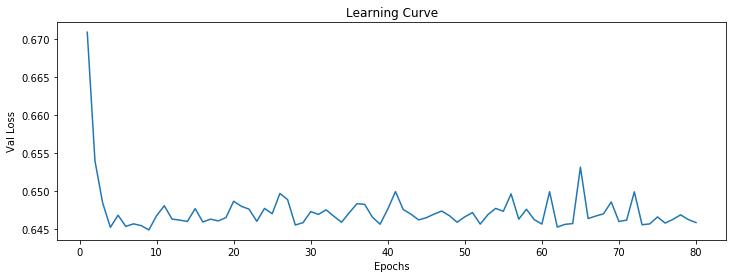

In [34]:
plt.plot(range(1, len(avg_val_loss_hist) + 1), avg_val_loss_hist)
plt.xlabel("Epochs")
plt.ylabel("Val Loss")
plt.title("Learning Curve")
plt.savefig(os.path.join(cwd, "fig", "learning_curve.png"))
plt.show()

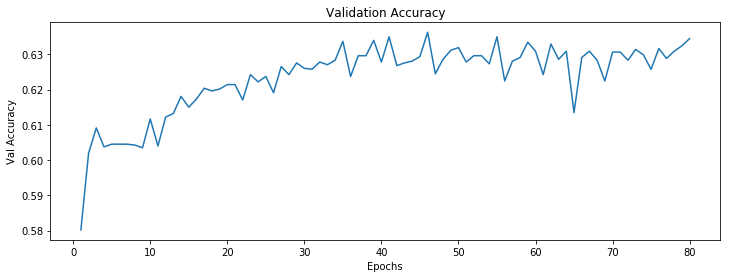

In [35]:
plt.plot(range(1, len(avg_val_acc_hist) + 1), avg_val_acc_hist)
plt.xlabel("Epochs")
plt.ylabel("Val Accuracy")
plt.title("Validation Accuracy")
plt.savefig(os.path.join(cwd, "fig", "validation_accuracy.png"))
plt.show()

## Final Model

In [36]:
num_epochs = 80
batch_size = 256
model = Build_Model()
history = model.fit(trn_data, trn_labl,
                    validation_data = (tst_data, tst_labl),
                    epochs = num_epochs, batch_size = batch_size, verbose = 0)

In [37]:
pred = model.predict(tst_data)
_ = deepcopy(tst_labl)
_["pred_p"] = pred
_["pred"] = pred > 0.5
_.T

,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,...,4329,4330,4331,4332,4333,4334,4335,4336,4337,4338
label,1,0,1,0,0,0,0,0,1,0,...,1,1,0,1,1,0,1,0,0,1
pred_p,0.499676,0.48608,0.506122,0.486758,0.506605,0.486499,0.461302,0.438383,0.429039,0.479641,...,0.493068,0.468562,0.491572,0.489253,0.48624,0.479485,0.491219,0.486421,0.493196,0.479279
pred,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [38]:
_[_[key_label] == 1].T

,3905,3907,3913,3917,3920,3921,3924,3926,3927,3928,...,4324,4325,4326,4327,4329,4330,4332,4333,4335,4338
label,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
pred_p,0.499676,0.506122,0.429039,0.460369,0.465693,0.480994,0.480892,0.480525,0.483096,0.517288,...,0.458124,0.454308,0.466418,0.490782,0.493068,0.468562,0.489253,0.48624,0.491219,0.479279
pred,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [39]:
_[_[key_label] == 0].T

,3906,3908,3909,3910,3911,3912,3914,3915,3916,3918,...,4309,4310,4312,4317,4319,4328,4331,4334,4336,4337
label,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pred_p,0.48608,0.486758,0.506605,0.486499,0.461302,0.438383,0.479641,0.501527,0.481346,0.513056,...,0.351175,0.363597,0.364828,0.425641,0.427863,0.471275,0.491572,0.479485,0.486421,0.493196
pred,False,False,True,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


## Analysis

In [40]:
summary = analysis.err_analyze(tst_labl.values, pred, threshold = 0.5, verbose = True)

baseline = 0.59217
tp = 86
tn = 207
fp = 50
fn = 91
precision = 0.63235
recall = 0.48588
accuracy = 0.67512
TPR = 0.48588
FPR = 0.19455


For t = 0.10, FPR = 0.91440, TPR = 0.98305
For t = 0.20, FPR = 0.81323, TPR = 0.93220
For t = 0.30, FPR = 0.66926, TPR = 0.90960
For t = 0.40, FPR = 0.42802, TPR = 0.81921
For t = 0.50, FPR = 0.19455, TPR = 0.48588
For t = 0.60, FPR = 0.00000, TPR = 0.00000
For t = 0.70, FPR = 0.00000, TPR = 0.00000
For t = 0.80, FPR = 0.00000, TPR = 0.00000
For t = 0.90, FPR = 0.00000, TPR = 0.00000


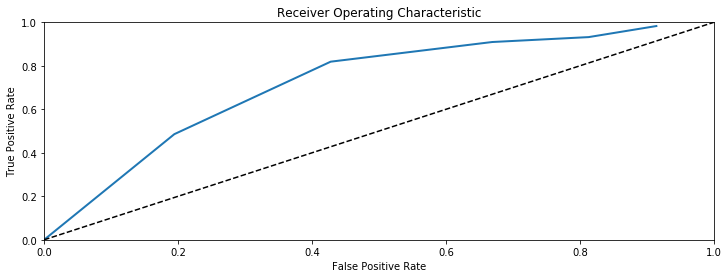

In [41]:
tprs, fprs, ts = analysis.discretize(tst_labl.values, pred)
analysis.plot_roc_curve(fprs, tprs, save_path = os.path.join(cwd, "fig", "roc.png"))

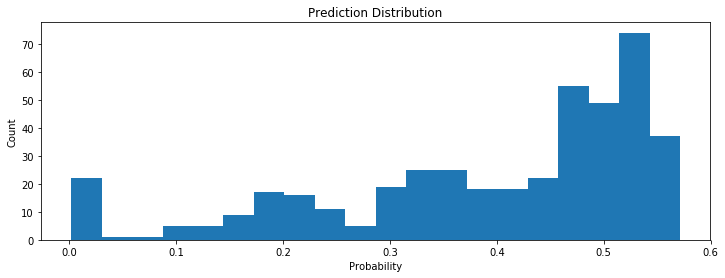

In [42]:
plt.hist(pred, 20)
plt.title("Prediction Distribution")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.savefig(os.path.join(cwd, "fig", "predict_prob.png"))